In [ ]:
import pickle
import numpy as np
from PIL import Image
import skimage as ski
import sys
import geopandas as gpd

sys.path.insert(0, "/home/adriano/projeto_mestrado/modules")

from Funcoes_gerais import funcoes

import background_generation as backgen

root_dir = f"/home/adriano/projeto_mestrado/modules"

img_dir = f'{root_dir}/Imagens/vessel_data/images/'
lab_dir = f'{root_dir}/Imagens/vessel_data/labels_20x/'
pickle_dir = f'{root_dir}/Vessel_Models_pickle'

img_especifica = 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X'
array_pickles = funcoes.ler_diretorios(pickle_dir)
vetor_informacoes = []

tracados = f'{root_dir}/Artificial_Lines/array_arquivos.json'
array_medial_path = backgen.retorna_paths(tracados)  

for i in range(len(array_medial_path)):  
  n_random = np.random.randint(0, len(array_pickles), size=1)
  print(n_random[0])
  path = (pickle_dir + f'/{array_pickles[n_random[0]]}')
  print(path)
  arquivo_pickle = pickle.load(open(path, 'rb'))
  print(arquivo_pickle)
  vessel_map = arquivo_pickle['vessel_model'].vessel_map 
  mapa_original = vessel_map.mapped_values,
  imagem_binaria_original = vessel_map.mapped_mask_values
  imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)
  imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais)
  rows, cols = mapa_original[0].shape
  distancia = (rows/2)
  caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(array_medial_path[i], 2) # type: ignore
  maior_valor_interpolado = np.max(caminhos_transladados_interpolado[0])
  mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original[0],maior_valor_interpolado)
  mapa_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor_interpolado)  
 
  dict = {
      "path": path,
      "arquivo_pickle": arquivo_pickle,
      "vessel_map": vessel_map,
      "mapa_original": mapa_original,
      "imagem_binaria_original": imagem_binaria_original,
      "imagem_binaria_sem_artefatos_laterais": imagem_binaria_sem_artefatos_laterais,  
      "imagem_binaria_sem_artefatos": imagem_binaria_sem_artefatos,
      "caminhos_transladados_interpolado": caminhos_transladados_interpolado,
      "maior_valor_interpolado": maior_valor_interpolado,
      "mapa_expandido_original": mapa_expandido_original,
      "mapa_expandido_bin": mapa_expandido_bin,
      "rows": rows,
      "cols": cols,
      "distancia": distancia
    }
  vetor_informacoes.append(dict)


for i in range(len(array_medial_path)):    

    caminhos_transladados_interpolado = vetor_informacoes[i]['caminhos_transladados_interpolado'] # type: ignore
    maior_valor_interpolado = vetor_informacoes[i]['maior_valor_interpolado'] # type: ignore
    distancia = vetor_informacoes[i]['distancia'] # type: ignore
    mapa_original = vetor_informacoes[i]['mapa_original'] # type: ignore
    imagem_binaria_sem_artefatos = vetor_informacoes[i]['imagem_binaria_sem_artefatos'] # type: ignore
    mapa_expandido_original = vetor_informacoes[i]['mapa_expandido_original'] # type: ignore
    mapa_expandido_bin = vetor_informacoes[i]['mapa_expandido_bin'] # type: ignore      

    print(distancia)
    if distancia < 30:    
      linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(caminhos_transladados_interpolado[0],distancia)
      gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])
      gp4.plot(cmap="tab10")

In [ ]:
from matplotlib import pyplot as plt


mapa_original = vetor_informacoes[0]['mapa_original'] # type: ignore
mapa_expandido_original = vetor_informacoes[0]['mapa_expandido_original'] # type: ignore
vessel_map = vetor_informacoes[0]['vessel_map'] # type: ignore
caminhos_transladados_interpolado = vetor_informacoes[0]['caminhos_transladados_interpolado'] # type: ignore
mapa_expandido_bin = vetor_informacoes[0]['mapa_expandido_bin'] # type: ignore


dst_array_np_mapa_original = backgen.retorna_dst_array_np_mapa_original(linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho,mapa_original[0])

img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.rotacionando_mapa_expandido(mapa_expandido_original,dst_array_np_mapa_original,maior_tamanho)

mask_map = backgen.criar_mascara_binaria_mapa(new_dst,img_out)

plt.figure(figsize=[10, 8])
plt.title("mask_map")
plt.imshow(mask_map, 'gray', vmin=0, vmax=1)
plt.plot()


mask_vaso = backgen.criar_mascara_binaria_vaso(vessel_map,new_origin,caminhos_transladados_interpolado[0],img_out)

plt.figure(figsize=[10, 8])
plt.title("mask_vaso")
plt.imshow(mask_vaso, 'gray', vmin=0, vmax=1)
plt.plot()

vaso_binario_rotacionado = backgen.criar_vaso_binario_expandido(mapa_expandido_bin,dst_array_np_mapa_original,maior_tamanho)

mapa_sem_artefatos = backgen.retirar_artefatos(img_out,mask_map)
#Ver aqui
#vaso_sem_artefatos = backgen.retirar_artefatos(img_out_bin,mask_vaso)

plt.figure(figsize=[10, 8])
plt.title("vaso_sem_artefatos")
plt.imshow(vaso_sem_artefatos, 'gray', vmin=0, vmax=1)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("mapa_sem_artefatos")
plt.imshow(mapa_sem_artefatos, 'gray', vmin=0, vmax=60)
plt.plot()

back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))

point = (50,50)
limiar = backgen.encontrar_pixel_mais_frequente(mapa_original[0])
background = back_artif
img_merged = backgen.inserindo_vaso_fundo2(mapa_sem_artefatos,vaso_sem_artefatos,background,point,limiar)

plt.figure(figsize=[20, 8])
plt.subplot(1,2,1)
plt.title("fundo com vaso")
plt.imshow(img_merged, 'gray', vmin=0, vmax=60)

plt.subplot(1,2,2)
plt.title("mapa_sem_artefatos")
plt.imshow(mapa_sem_artefatos, 'gray', vmin=0, vmax=60)



In [ ]:
mapa_original = vetor_informacoes[0]['mapa_original'] # type: ignore
mapa_expandido_original = vetor_informacoes[0]['mapa_expandido_original'] # type: ignore
vessel_map = vetor_informacoes[0]['vessel_map'] # type: ignore
caminhos_transladados_interpolado = vetor_informacoes[0]['caminhos_transladados_interpolado'] # type: ignore

dst_array_np_mapa_original = backgen.retorna_dst_array_np_mapa_original(linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho,mapa_original[0])

img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.rotacionando_mapa_expandido(mapa_expandido_original,dst_array_np_mapa_original,maior_tamanho)

backgen.plot(img_proper, img_out, new_src, new_dst, 60)

In [32]:
print(len(caminhos_transladados_interpolado[0]))

7


[]

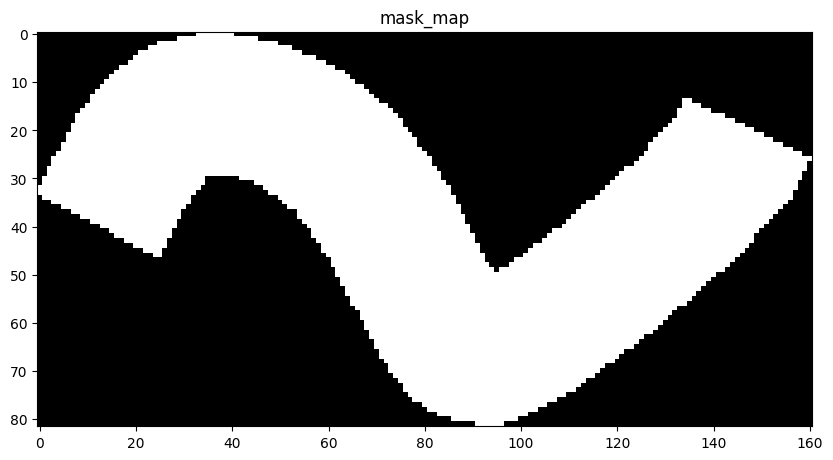

In [22]:
mask_map = backgen.criar_mascara_binaria_mapa(new_dst,img_out)

plt.figure(figsize=[10, 8])
plt.title("mask_map")
plt.imshow(mask_map, 'gray', vmin=0, vmax=1)
plt.plot()


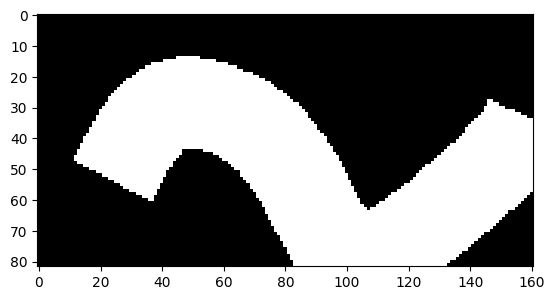

In [34]:
# dst_array_np = backgen.retorna_dst_array_np(linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho)

# rows, cols = mapa_expandido_original.shape[0], mapa_expandido_original.shape[1]

# src_cols = np.linspace(0, cols, maior_tamanho)
# src_rows = np.linspace(-1, rows, 3)
# src_cols, src_rows = np.meshgrid(src_cols,src_rows)
# src = np.dstack([src_cols.flat, src_rows.flat])[0]


# img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.transform_v2(src, dst_array_np, mapa_expandido_original)
# backgen.plot(img_proper, img_out, new_src, new_dst,vmax=60)


import skimage as ski


linha_minima = int(np.min(np.rint(vessel_map.path2_mapped)))
linha_maxima  = int(np.max(np.rint(vessel_map.path1_mapped)))

diametro_maximo_vaso = (linha_maxima-linha_minima)/2



linha_mask_esquerda,linha_mask_central,linha_mask_direita, max_tam = backgen.retorna_linhas_offset_posicao_tamanho(caminhos_transladados_interpolado[0],diametro_maximo_vaso)

dst_mask_np = backgen.retorna_dst_array_np(linha_mask_esquerda,linha_mask_central,linha_mask_direita, max_tam)



new_dst -= new_origin

tam = len(new_dst)

div = tam//3

vetor_div =[div,div*2,div*3]

parte_direita = new_dst[0:vetor_div[0]]
parte_centro = new_dst[vetor_div[0]:vetor_div[1]] 
parte_esquerda = new_dst[vetor_div[1]:vetor_div[2]] 

lista_somada = np.concatenate((parte_esquerda, parte_direita[::-1]))
polygon = np.array(lista_somada)[:,::-1]
mask_vessel = ski.draw.polygon2mask(img_out.shape, polygon) # type: ignore
mask_vessel.astype(int)
mask_vessel_sq = mask_vessel.squeeze()

plt.imshow(mask_vessel, 'gray')

In [37]:
print(len(new_dst))
print(len(dst_mask_np))

117
72


[]

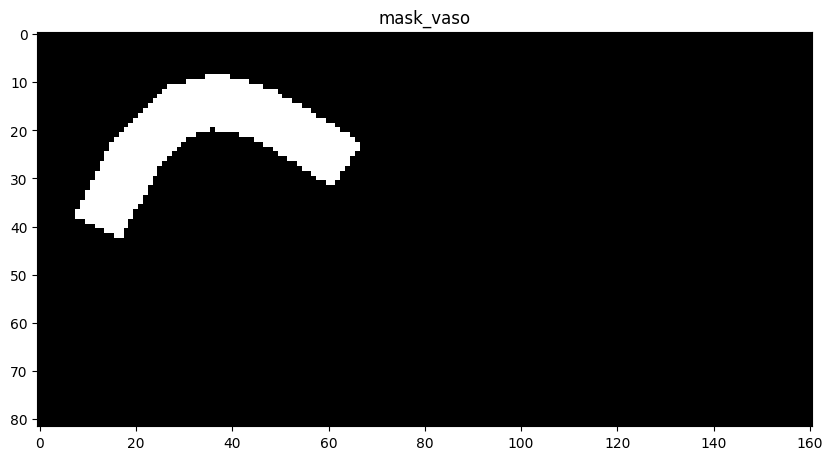

In [30]:

mask_vaso = backgen.criar_mascara_binaria_vaso(vessel_map,new_origin,caminhos_transladados_interpolado[0],img_out)

plt.figure(figsize=[10, 8])
plt.title("mask_vaso")
plt.imshow(mask_vaso, 'gray', vmin=0, vmax=1)
plt.plot()

[-12 -14]
[[ 7.14607841 37.72357687]
 [ 8.73258742 34.74615585]
 [10.31909643 31.76873483]
 [11.90560544 28.79131381]
 [13.49211445 25.81389279]
 [15.07862346 22.83647177]
 [17.01291647 20.10109222]
 [19.39850307 17.71550563]
 [21.78408966 15.32991904]
 [24.16967625 12.94433245]
 [26.88847981 11.01237392]
 [30.14159734 10.12017769]
 [33.40064897  9.24803712]
 [36.68492562  8.50809376]
 [39.98808343  9.1155272 ]
 [43.25303625  9.96530944]
 [46.51798907 10.81509168]
 [49.56143262 12.2377141 ]
 [52.50698628 13.88263368]
 [55.45253994 15.52755326]
 [58.35418632 17.24619691]
 [61.19764673 19.06190054]
 [64.04110714 20.87760418]
 [66.88456755 22.69330781]
 [12.         40.30997305]
 [13.40109463 37.68052147]
 [14.80218927 35.0510699 ]
 [16.2032839  32.42161833]
 [17.60437853 29.79216676]
 [19.00547317 27.16271518]
 [20.4065678  24.53326361]
 [22.48597849 22.4062048 ]
 [24.59276297 20.29942032]
 [26.69954746 18.19263583]
 [28.84891616 16.15963669]
 [31.72708435 15.38942267]
 [34.60525253 14.6

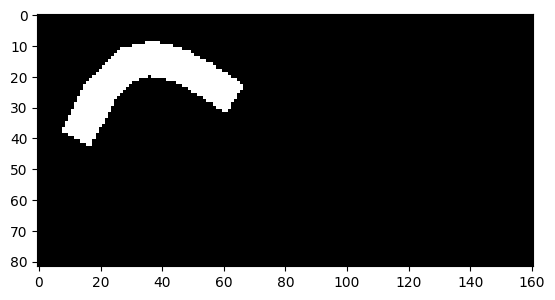

In [25]:
plt.imshow(mask_vessel_sq, 'gray')

print(new_origin)

print(dst_mask_np)